In [1]:
import os
import time
import bz2
import codecs
import pickle as pkl

import numpy as np
from scipy import stats

from collections import defaultdict

import matplotlib.pyplot as plt
from pylab import polyfit
%matplotlib inline

from models import *

In [2]:
plt.rcParams["figure.figsize"] = (15, 15)

In [3]:
dep_based = load_model("deps.words")
bow2_based = load_model("bow2.words")
bow5_based = load_model("bow5.words")

In [4]:
all_models = [['Dependency', dep_based], 
              ['BoW with k = 2', bow2_based], 
              ['BoW with k = 5', bow5_based]]

In [5]:
# Read Simlex999.txt 
def read_sim_file(filename):
    pairs_list = []
    pairs_dict = {}
    with open(filename, "r") as f:
        for _, line in enumerate(f):
            line = line.strip().split()
            pairs_list.append((line[0], line[1], line[3]))
            pairs = pairs_list[1:]
    for word1, word2, score in pairs:
        if word1 not in pairs_dict.keys():
            pairs_dict[word1] = []
        pairs_dict[word1].append((word2,float(score)))
# Sorting by scores
    for word1, list_value in pairs_dict.items():
        list_value.sort(key=lambda _: -_[1])
    return pairs_dict


In [6]:
#Read MEN-Dataset-Natural-Full-Form
def read_men_file(filename):
    pairs_list = []
    pairs_dict = {}
    with open(filename, "r") as f:
        for _, line in enumerate(f):
            line = line.strip().split()
            pairs_list.append((line[0], line[1], line[2]))
    for word1, word2, score in pairs_list:
        if word1 not in pairs_dict.keys():
            pairs_dict[word1] = []
        pairs_dict[word1].append((word2, float(score)))
    
    for key, value in pairs_dict.items():
        value.sort(key=lambda _: -_[1])
        
    return pairs_dict

In [7]:
simlex_999 = read_sim_file("data/SimLex-999/SimLex-999.txt")

In [84]:
simlex_999["bar"]

[('cage', 2.8), ('jail', 1.9)]

In [9]:
men_natural = read_men_file("data/MEN/MEN_dataset_natural_form_full")

In [85]:
men_natural["bar"]

[('cocktail', 44.0),
 ('pub', 44.0),
 ('restaurant', 41.0),
 ('sushi', 37.0),
 ('cafe', 32.0),
 ('diner', 32.0),
 ('relaxed', 24.0),
 ('stairs', 17.0),
 ('boat', 15.0),
 ('ship', 15.0),
 ('female', 13.0)]

In [86]:
dep_based.most_similar("bar", score = False, n = 3)

['bars', 'restaurant', 'nightclub']

In [87]:
bow2_based.most_similar("bar", score = False, n = 3)

['bars', 'restaurant', 'bathhouse']

In [88]:
bow5_based.most_similar("bar", score = False, n = 3)

['grill', 'bars', 'restaurant']

In [14]:
eval_models = [["SimLex-999", simlex_999], 
               ["MEN (Natural) Full Form", men_natural]]

In [15]:
def is_present(word):
    for model_name, model in all_models:
        if word not in model.word_index:
            return False
    return True

In [16]:
def compute_similarity(model, word1, word2):
    return cosine_similarity(model[word1], model[word2])

Model:  SimLex-999
SimLex-999  vs.  Dependency  ~ Spearman Correlation:  0.4456
SimLex-999  vs.  Dependency  ~ Pearson Correlation:  0.4619


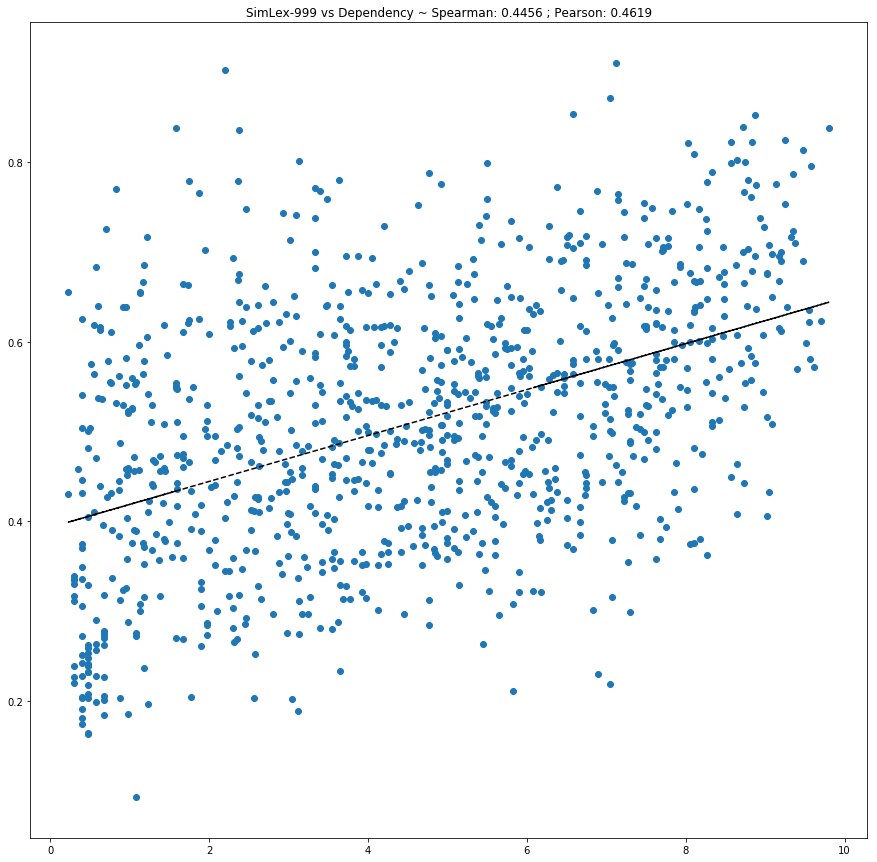

SimLex-999  vs.  BoW with k = 2  ~ Spearman Correlation:  0.4141
SimLex-999  vs.  BoW with k = 2  ~ Pearson Correlation:  0.4285


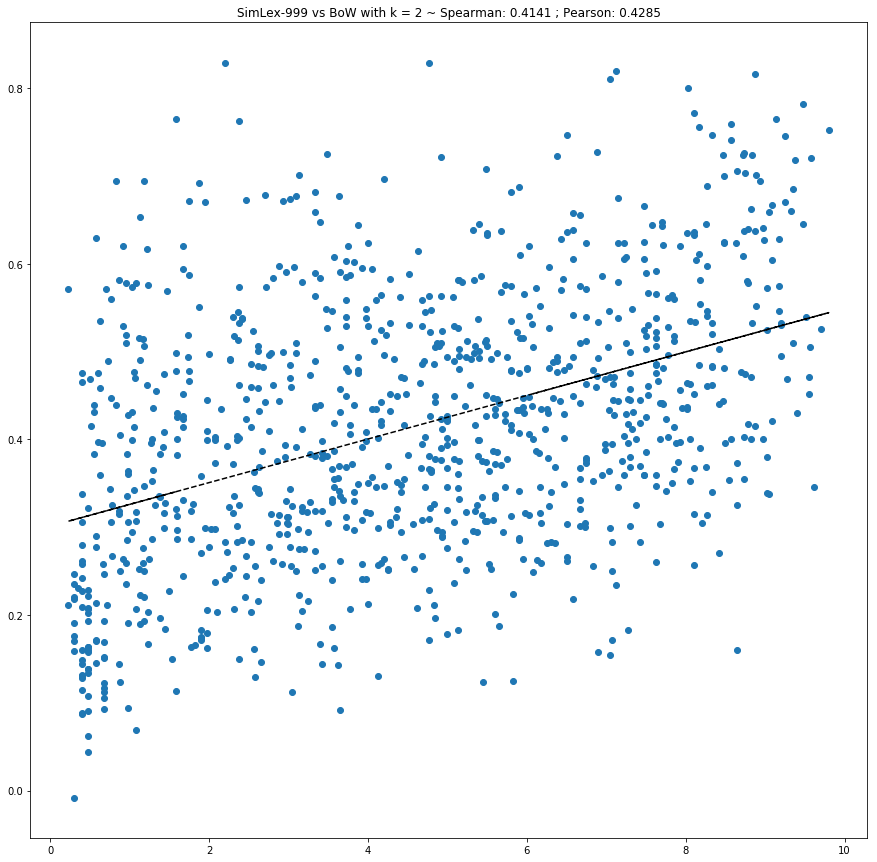

SimLex-999  vs.  BoW with k = 5  ~ Spearman Correlation:  0.3674
SimLex-999  vs.  BoW with k = 5  ~ Pearson Correlation:  0.3756


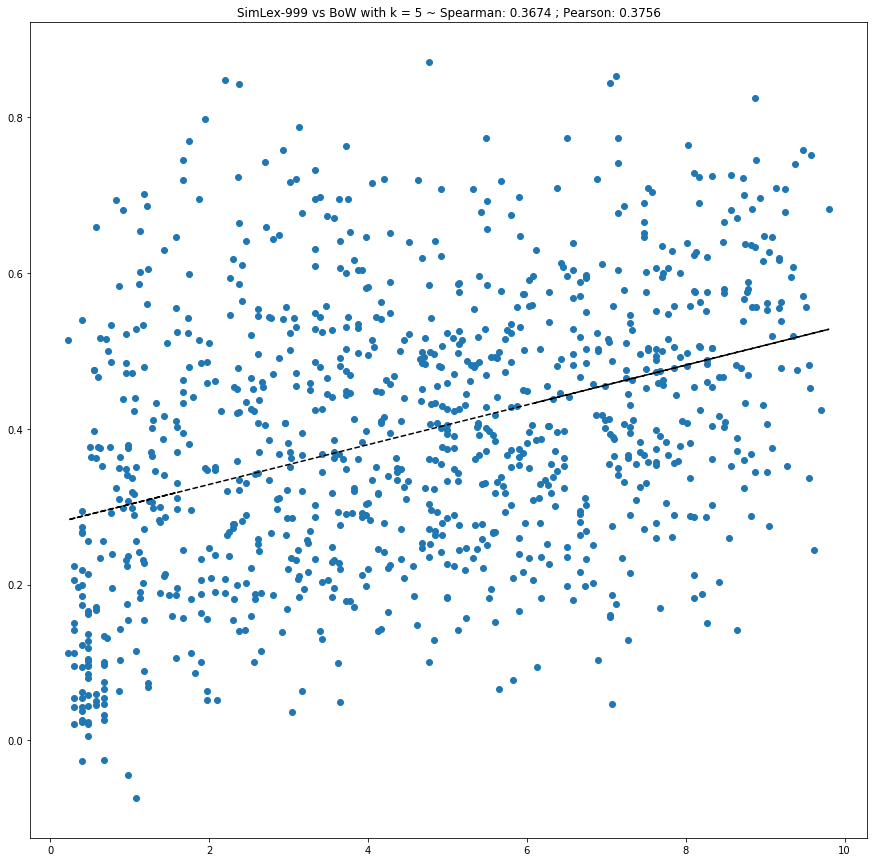

Model:  MEN (Natural) Full Form
MEN (Natural) Full Form  vs.  Dependency  ~ Spearman Correlation:  0.6178
MEN (Natural) Full Form  vs.  Dependency  ~ Pearson Correlation:  0.5974


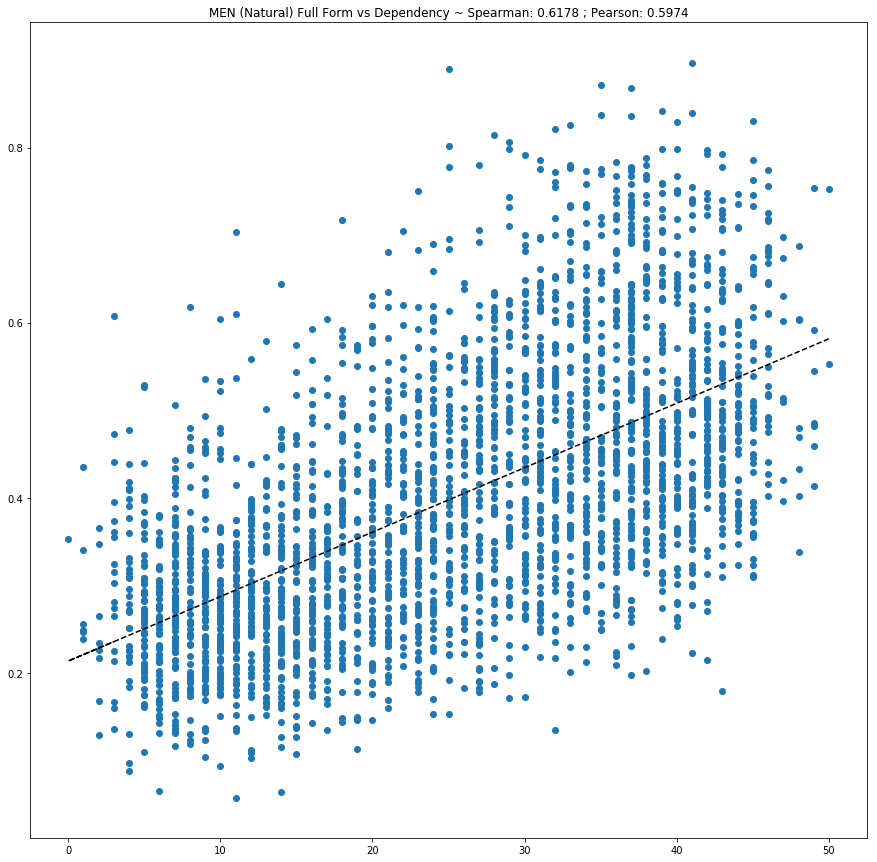

MEN (Natural) Full Form  vs.  BoW with k = 2  ~ Spearman Correlation:  0.6999
MEN (Natural) Full Form  vs.  BoW with k = 2  ~ Pearson Correlation:  0.6777


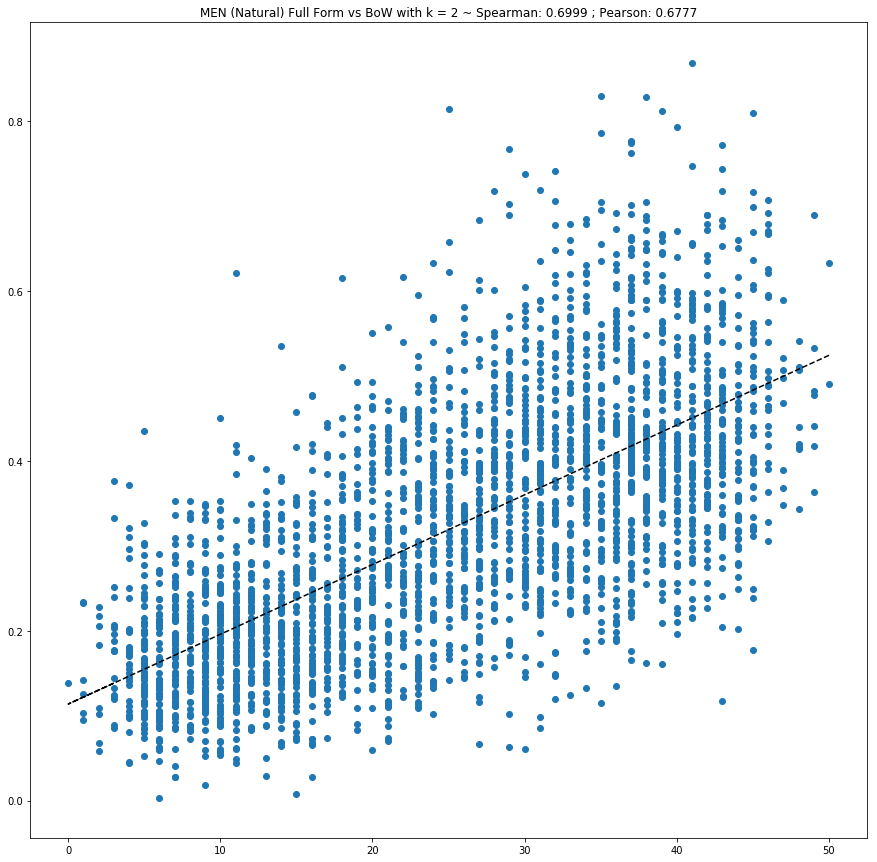

MEN (Natural) Full Form  vs.  BoW with k = 5  ~ Spearman Correlation:  0.7232
MEN (Natural) Full Form  vs.  BoW with k = 5  ~ Pearson Correlation:  0.7082


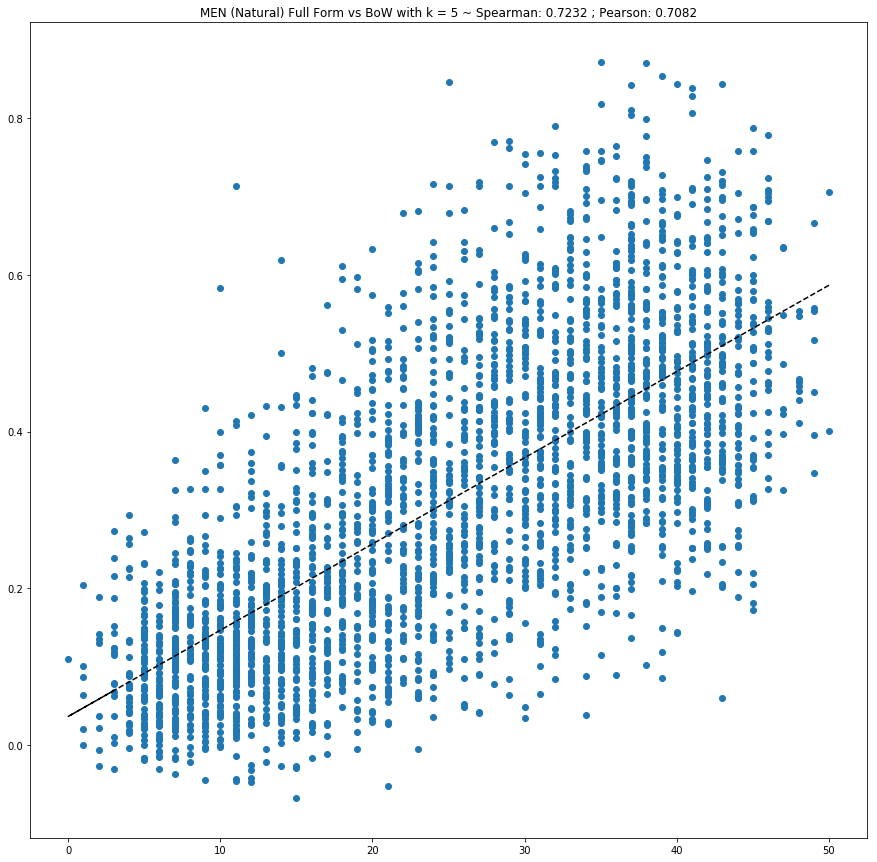

In [17]:
# Evaluation
for eval_name, eval_data in eval_models:
    print("Model: ", eval_name)
    model_similarities = defaultdict(list)
    for word1, associated_words in eval_data.items():
        for word2, score in associated_words:
            if not is_present(word1):
                continue
            if not is_present(word2):
                continue
            model_similarities[eval_name].append(score)
            #print(word1, word2)
            for model_name, model in all_models:
                model_similarities[model_name].append(compute_similarity(model, word1, word2))
        #print(model_similarities)
        
    
    eval_scores = model_similarities[eval_name]
    del model_similarities[eval_name]
    
    for model_name, model_scores in model_similarities.items():
#         print(len(eval_scores), len(model_scores))
        rho, _ = stats.spearmanr(eval_scores, model_scores, axis = None)
        val, _ = stats.pearsonr(eval_scores, model_scores)
        
        rho = round(rho, 4)
        val = round(val, 4)
        
        print(eval_name, ' vs. ', model_name, ' ~ Spearman Correlation: ', rho)
        print(eval_name, ' vs. ', model_name, ' ~ Pearson Correlation: ', val)
    
        plt.figure()
        plt.scatter(eval_scores, model_scores)
        plt.title("{} vs {} ~ Spearman: {} ; Pearson: {}".format(eval_name, model_name, rho, val))

        m,b = polyfit(eval_scores, model_scores, 1) 

        plt.plot(eval_scores, m*np.array(eval_scores)+b, '--k')
        plt.show()

# Analysis

### Word Similarity Results

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{font-weight:bold;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>

<table class="tg">
  <tr>
    <th rowspan="2" class ="tg-88nc"><center>Correlation<br>Coefficient vs.<br>Models</center></th>
    <th colspan="3" class ="tg-88nc"><center>SimLex999</center></th>
    <th colspan="3" class ="tg-88nc"><center>MEN</center></th>
  </tr>
  <tr>
    <td>Dependency</td>
    <td>BoW, k = 2</td>
    <td>BoW, k = 5</td>
    <td>Dependency</td>
    <td>BoW, k = 2</td>
    <td>BoW, k = 5<br></td>
  </tr>
  <tr>
    <td>Spearman</td>
    <td>0.4456</td>
    <td>0.4141</td>
    <td>0.3674</td>
    <td>0.6178</td>
    <td>0.6999</td>
    <td>0.7232</td>
  </tr>
  <tr>
    <td>Pearson</td>
    <td>0.4619</td>
    <td>0.4285</td>
    <td>0.3756</td>
    <td>0.5974</td>
    <td>0.6777</td>
    <td>0.7082</td>
  </tr>
</table>

The following observations can be made from analysing these correlation coefficient results:
- Simlex is a way of measuring the similarity between words, whereas MEN scores words based on their "relatedness" (both are derived from human judgments). 
- Since the word representation models capture topical contexts and syntactical contexts more than similarity, we see poor results on the SimLex999 task. Dependency based models score better than linear BoW since syntactical/functional words (pair) tend to be more similar than just words within a certain window. But, BoW (k=2) still performs better than (k=5) due to smaller window size.
- MEN measures higher Spearman and Pearson Correlation since it captures related words with respect to context. Consequently, the scores increase while we move from a dependency based model to a bag of words model (k = 2, 5). This is because BoW models derive contexts within a window size (k) whereas Dependency models capture context based on the syntactic relationship between the words (arc-based, usually between a pair of words),  thereby reducing the "relatedness" measure. 
- Another reason for the drastic difference in the Spearman/Pearson scores between the Simlex999 and MEN models can  be attributed from a higher correlation in the MEN plots versus a poor correlation in Simlex that has been computed above. 

### Qualitative Analysis

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-88nc{font-weight:bold;border-color:inherit;text-align:center}
.tg .tg-l711{border-color:inherit}
.tg .tg-us36{border-color:inherit;vertical-align:top}
.tg .tg-3wey{font-style:italic;border-color:inherit}
.tg .tg-00jj{font-style:italic;border-color:inherit;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-88nc">Target Word<br>(Top 3 results)</th>
    <th class="tg-88nc">SimLex999<br></th>
    <th class="tg-88nc">MEN<br></th>
    <th class="tg-88nc">BoW, k = 2<br></th>
    <th class="tg-88nc">BoW, k = 5<br></th>
    <th class="tg-88nc">Dependency<br></th>
  </tr>
  <tr>
    <td class="tg-3wey">Chicken</td>
    <td class="tg-l711">Steak<br>Rice</td>
    <td class="tg-l711">Meat<br>Soup<br>Rice</td>
    <td class="tg-l711">Pork<br>Veal<br>Beef</td>
    <td class="tg-l711">Pork<br>Stew<br>Fried</td>
    <td class="tg-l711">Veal<br>Mutton<br>Pork</td>
  </tr>
  <tr>
    <td class="tg-3wey">Bread</td>
    <td class="tg-l711">Flour<br>Cheese</td>
    <td class="tg-l711">Sandwich<br>Eat<br>Potatoes</td>
    <td class="tg-l711">Breads<br>Unleavened<br>Cake</td>
    <td class="tg-l711">Cheese<br>Breads<br>Butter</td>
    <td class="tg-l711">Pasta<br>Yogurt<br>Tofu</td>
  </tr>
  <tr>
    <td class="tg-3wey">Sun</td>
    <td class="tg-l711">Sky</td>
    <td class="tg-l711">Sunlight<br>Sunshine<br>Sunrise</td>
    <td class="tg-l711">Moon<br>Photosphere<br>Arkestra [1]</td>
    <td class="tg-l711">Moon<br>Wukong [2]<br>Sky</td>
    <td class="tg-l711">Moon<br>Sky<br>Jupiter</td>
  </tr>
  <tr>
    <td class="tg-00jj">Happy</td>
    <td class="tg-us36">Cheerful<br>Glad<br>Young</td>
    <td class="tg-us36">Smile<br>Love<br>Kids</td>
    <td class="tg-us36">Happier<br>Pleased<br>Glad</td>
    <td class="tg-us36">Glad<br>Pleased<br>Happier</td>
    <td class="tg-us36">Ecstatic<br>Glad<br>Anxious</td>
  </tr>
  <tr>
    <td class="tg-00jj">Bar</td>
    <td class="tg-us36">Cage<br>Jail</td>
    <td class="tg-us36">Cocktail<br>Pub<br>Restaurant</td>
    <td class="tg-us36">Bars<br>Restaurant<br>Bathhouse</td>
    <td class="tg-us36">Grill<br>Bars<br>Restaurant</td>
    <td class="tg-us36">Bars<br>Restaurant<br>Nightclub</td>
  </tr>
</table>

[1] This word comes from <i>The Sun Ra Arkestra</i>, a musical group <br> [2] Wukong <i>Sun</i> is a fictional character

The table above describes some interesting words (and their most similar words) that we came across while experimenting with the models. Since SimLex999 has only 999 words we couldn't inspect on a wide cateogory of words. Hence, we're reporting on the most interesting ones we stumbled across. The following observations can be made:
- Most of the words such as _Chicken_, _Bread_ and _Happy_ associated well with other similar words across different setups. 
    - _Chicken_ was paired with other meat choices and often its accompaniment, such as _rice_ or _soup_.
    - _Bread_ is often associated as an ingredient or again as an accompaniment across the relatedness models (MEN, BoW & Dependency) while SimLex provides an exception, where _flour_ is scored as the most similar word to bread since it is made from that.
    - _Sun_ displayed some interesting choices of words. While most of the words across the models captured phenomenas associated with light and planetary objects, two obscure matches were found at [1], [2]. These pecularities arise due to the different window sizes.
    - _Happy_ captures similar adjective across all models
    - The two most distinctive meanings of _Bar_ are captured through similarity by SimLex (attributes to _bars_ of a _cage_ and behind _bars_ i.e _jail_) and relatedness (_restaurant_, _pub_ etc) by topical models such as MEN, BoW and dependency models. 